## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import os
import numpy as np
import math

os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda 
from numba import vectorize, float32, int16

@vectorize([float32(float32)], target='parallel', fastmath=True) 

def vec_log(x):
    c =  np.log(x)
    return c

def vec_exp(x):
    c =  np.exp(x)
    return c

A = np.float32([2,5,10,3,8])

print('Log:',vec_log(A))
print('Exp:',vec_exp(A))

Log: [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Exp: [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [2]:
@vectorize([float32(float32)], target='parallel', fastmath=True)

def gauss(x):
    sigma = 1
    mean  = 1
    return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-((x-mean)/sigma)**2 / 2)

size = 100000
a = np.linspace(-3, 3, size, dtype='float32')

gauss(a)

array([0.00013383, 0.00013386, 0.00013389, ..., 0.05400392, 0.05399745,
       0.05399097], dtype=float32)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

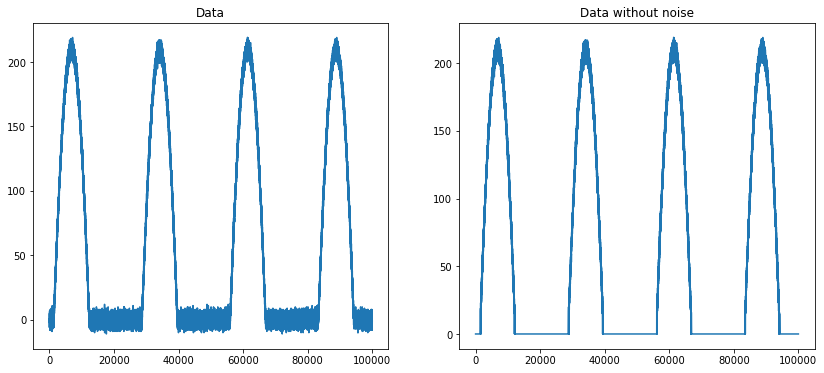

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

@vectorize([int16(int16,int16)], target='parallel', fastmath=True)
def zero_suppression(x,threshold):
    if x < threshold:
        return 0
    else:
        return x
    
data_suppressed = zero_suppression(data,15)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.plot(data)
ax1.set_title('Data')
ax2.plot(data_suppressed)
ax2.set_title('Data without noise')
plt.show()


## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [4]:
import math
X = np.random.rand(3,3)
Y = np.random.rand(3,3)
k = np.zeros((3,3), dtype='float32')

In [5]:
@cuda.jit
def sigmoid_kernel(x,y,k,alpha,c):
    
    row, col = cuda.grid(2)
    
    if row < k.shape[0] and col < k.shape[1]:
        tmp = 0.
        for i in range(x.shape[0]):
            tmp += x[i, row] * y[i, col]
            
        k[row, col] = math.tanh(alpha * tmp + c)

sigmoid_kernel[(1,1), (3,3)](X, Y, k, 1., 1.)
print(k)

[[0.90642047 0.92408466 0.79388106]
 [0.84826165 0.8635366  0.78722775]
 [0.9120118  0.93178475 0.8384949 ]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [ ]:
@cuda.jit
def cos_kernel_3D(io_array):
    row, col, l = cuda.grid(3)
    if row < io_array.shape[0] and col < io_array.shape[1] and l < io_array.shape[2]:
        io_array[row][col][l] *= math.cos(io_array[row][col][l]) 
x = np.random.normal(size=(256,256,256))

threadsperblock = (16, 4, 4)
blockspergrid_x = int(math.ceil(x.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(x.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(x.shape[2] / threadsperblock[2]))

blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

cos_kernel_3D[blockspergrid, threadsperblock](x)

print(x)

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [8]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(100, size=(24,12))
B = np.random.randint(100, size=(12,22)) 
C = np.zeros((24,12))

# Configure the blocks
threadsperblock = (24, 22)
blockspergrid_x = 1
blockspergrid_y = 1
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A, B, C)
print(C)

[[26131. 16736. 20337. 31814. 18918. 20952. 20339. 36905. 28824. 23926.
  22363. 26043.]
 [33831. 24906. 24760. 33960. 28803. 27642. 24959. 38257. 31592. 27489.
  23178. 32009.]
 [24044. 23230. 18501. 23794. 21594. 23483. 20964. 32439. 25714. 20427.
  18130. 25063.]
 [27363. 18577. 19647. 27127. 19544. 19381. 20344. 35056. 23002. 22673.
  20748. 24007.]
 [22321. 21337. 18462. 23109. 18399. 18116. 15932. 33382. 23112. 23518.
  23995. 25109.]
 [33727. 23064. 25335. 41480. 26996. 25281. 27715. 41776. 21659. 33955.
  24832. 29587.]
 [17021. 23215. 13961. 22563. 17141. 17698. 14542. 30434. 18070. 21217.
  20614. 20833.]
 [27351. 20643. 21979. 25001. 20114. 16776. 19603. 36537. 23074. 26571.
  22898. 23311.]
 [34858. 23160. 25343. 36739. 23741. 24187. 23640. 43108. 27317. 29728.
  27429. 32098.]
 [25182. 25344. 19824. 29225. 23810. 22668. 19940. 39064. 23707. 30153.
  29484. 26857.]
 [31819. 23126. 20934. 36964. 19559. 28330. 26940. 43304. 30092. 24341.
  25243. 34183.]
 [28831. 17468. 23023